## Imports

In [1]:
import os
import sys
sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Fold 5

In [2]:
cluster = '5'
fold = '5'
peak = 'overlap'
gwas = '23andme_PD'

## Prepare Reference Alleles

In [3]:
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 19


## Prepare Alternate Alleles

In [4]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 19


## Find Alternate Alleles that Break Accessibility

In [5]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
11,11,chr4,90759046,90759047,rs2619363,209,G,C,1.713133,1.167826,-0.545307
18,18,chr4,980931,980932,rs10902762,208,G,A,0.434952,0.133087,-0.301865
2,2,chr4,90644389,90644390,rs74329237,209,G,A,0.648740,0.385108,-0.263632
1,1,chr4,90644344,90644345,rs79596632,209,G,A,0.861903,0.628621,-0.233282
12,12,chr4,90759046,90759047,rs2619363,209,G,T,1.713133,1.486229,-0.226904
5,5,chr4,90674430,90674431,rs356168,209,G,A,1.982032,1.828993,-0.153039
0,0,chr4,90644280,90644281,rs17016071,209,A,G,0.694145,0.550188,-0.143958
9,9,chr4,90757308,90757309,rs1372519,209,G,A,0.635818,0.561051,-0.074767
6,6,chr4,90674450,90674451,rs3756054,209,T,C,1.798514,1.743263,-0.055251
10,10,chr4,90757504,90757505,rs1372520,209,C,T,0.690797,0.636970,-0.053827


## Get 10 bp around SNP

In [5]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

CCAATCAGCGCCTGCCAGAC
CCAATCAGCG | CCTGCCAGAC
CCTGGCCGCGCCCCCGGTGG
CCTGGCCGCG | CCCCCGGTGG
AATATTTCCGGAACACAATA
AATATTTCCG | GAACACAATA
AAAGGAAACGCTGTTTTTCT
AAAGGAAACG | CTGTTTTTCT
CCAATCAGCGCCTGCCAGAC
CCAATCAGCG | CCTGCCAGAC


## Visualize Top Sequences

In [ ]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [6]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
17,17,chr4,980895,980896,rs11248061,208,C,A,0.938849,1.269532,0.330683
15,15,chr4,90837531,90837532,rs3775472,209,C,A,0.044761,0.300344,0.255583
3,3,chr4,90644453,90644454,rs8180209,209,A,G,-0.177659,-0.030345,0.147313
4,4,chr4,90644507,90644508,rs8180214,209,G,A,-0.301841,-0.288342,0.013499
8,8,chr4,90757293,90757294,rs1372518,209,C,A,0.580568,0.580010,-0.000558
14,14,chr4,90837126,90837127,rs10516850,209,A,G,1.100391,1.085653,-0.014738
16,16,chr4,980463,980464,rs4690220,208,A,G,1.100147,1.081240,-0.018907
7,7,chr4,90729746,90729747,rs2619368,209,G,T,-0.007071,-0.031909,-0.024838
13,13,chr4,90837104,90837105,rs78586832,209,A,G,1.072590,1.042901,-0.029690
10,10,chr4,90757504,90757505,rs1372520,209,C,T,0.690797,0.636970,-0.053827


## Get 10 bp around SNP

In [7]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

CCCCCGCGCAGCGCTGCTGG
CCCCCGCGCA | GCGCTGCTGG
AAAAACAAAAAAACAAACAA
AAAAACAAAA | AAACAAACAA
TTCTACACCGAGCAATTCTC
TTCTACACCG | AGCAATTCTC
ATTCAAATCAGACACTATCT
ATTCAAATCA | GACACTATCT
GTGGTTCAAACTCAGGCAAA
GTGGTTCAAA | CTCAGGCAAA


## Visualize Top Sequences

Index:  17  Importance:  1.269531884  RSID:  rs11248061 chr4 :  980895  -  980896  Locus:  208
Minor Allele:  A


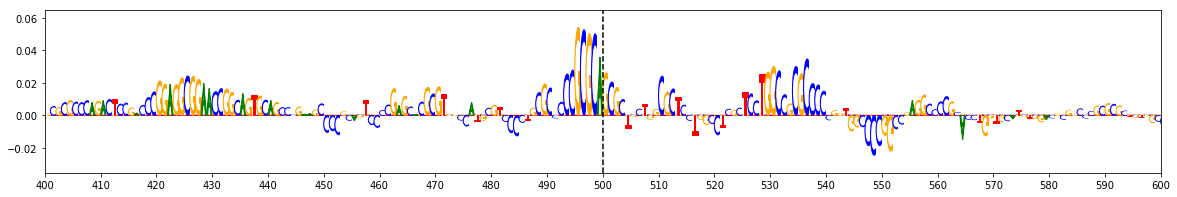

Index:  17  Importance:  0.93884861001  RSID:  rs11248061
Major Allele:  C


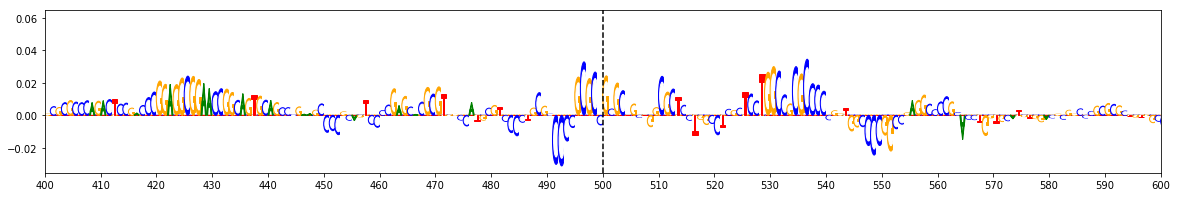

Index:  17  Delta:  0.3306832739900001  RSID:  rs11248061
Minor - Major:  A - C


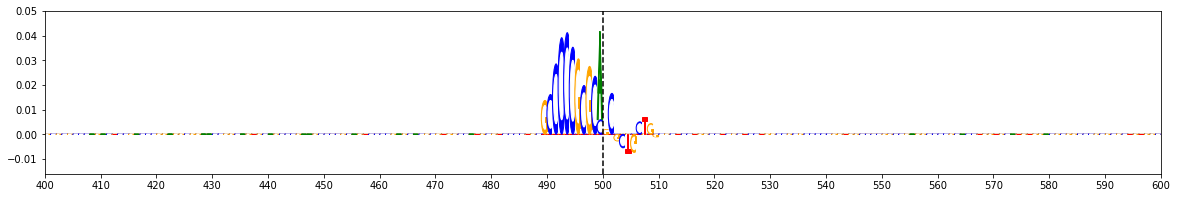

In [8]:
for idx in seq_df.iloc[:1]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

# Fold 7

## Prepare Reference Alleles

In [10]:
cluster = '5'
fold = '6'
peak = 'overlap'
gwas = '23andme_PD'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 23


## Prepare Alternate Alleles

In [11]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 23


## Find Alternate Alleles that Break Accessibility

In [12]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
8,8,chr7,65207197,65207198,rs117889818,211,G,A,0.022377,-0.282110,-0.304487
10,10,chr7,65447241,65447242,rs2279904,211,C,A,2.276457,1.998164,-0.278293
20,20,chr7,66147588,66147589,rs4717309,211,T,C,0.274939,0.070406,-0.204532
18,18,chr7,66119816,66119817,rs4078168,211,C,G,1.519777,1.331249,-0.188527
5,5,chr7,23146188,23146189,rs2072369,210,A,G,1.797151,1.610001,-0.187150
19,19,chr7,66119816,66119817,rs4078168,211,C,T,1.519777,1.346592,-0.173185
4,4,chr7,23146188,23146189,rs2072369,210,A,C,1.797151,1.636331,-0.160821
9,9,chr7,65215636,65215637,rs79920030,211,T,G,0.295255,0.149110,-0.146145
17,17,chr7,66083593,66083594,rs17228728,211,C,T,0.761731,0.706852,-0.054879
16,16,chr7,65925019,65925020,rs12532383,211,G,A,1.477516,1.437021,-0.040495


## Get 10 bp around SNP

In [13]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

TGGGAGGACGGCTTGGGCCC
TGGGAGGACG | GCTTGGGCCC
AGGGCGGGTCGCGTGACGCG
AGGGCGGGTC | GCGTGACGCG
CGTCCAGGATGCTGGCTCCG
CGTCCAGGAT | GCTGGCTCCG
GGCCGCCCTCGGCTCCCTTA
GGCCGCCCTC | GGCTCCCTTA
GCTGGCCTGACATCAGCTGC
GCTGGCCTGA | CATCAGCTGC


## Visualize Top Sequences

Index:  8  Importance:  0.02237695240000004  RSID:  rs117889818   chr7 : 65207197 - 65207198  Locus:  211
Major Allele:  G


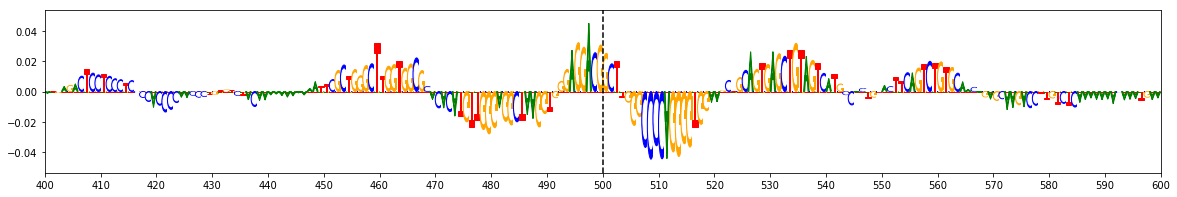

Index:  8  Importance:  -0.2821099523  RSID:  rs117889818
Minor Allele:  A


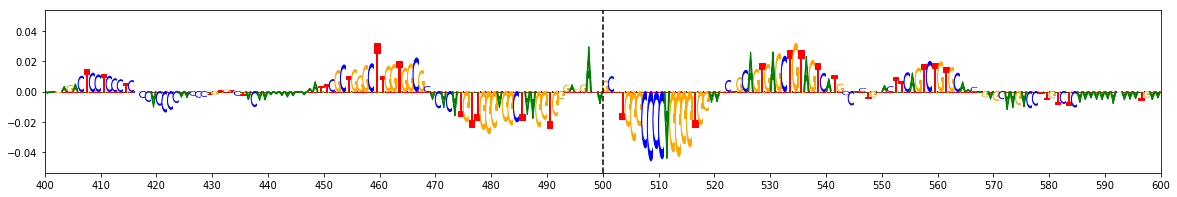

Index:  8  Delta:  -0.30448690470000006  RSID:  rs117889818
Minor - Major:  A - G


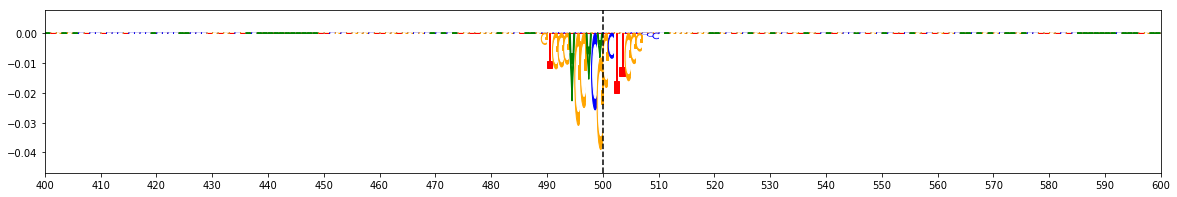

Index:  10  Importance:  2.27645713  RSID:  rs2279904   chr7 : 65447241 - 65447242  Locus:  211
Major Allele:  C


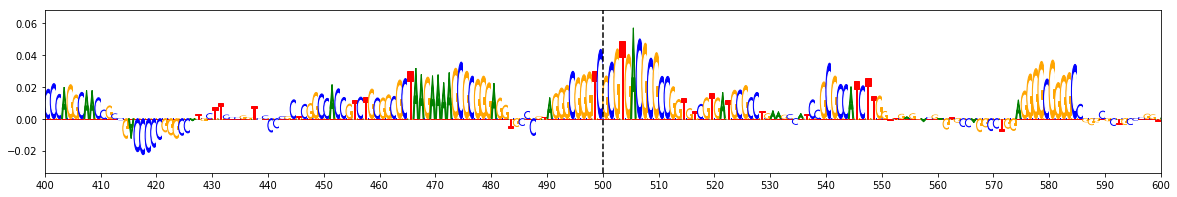

Index:  10  Importance:  1.9981641129999999  RSID:  rs2279904
Minor Allele:  A


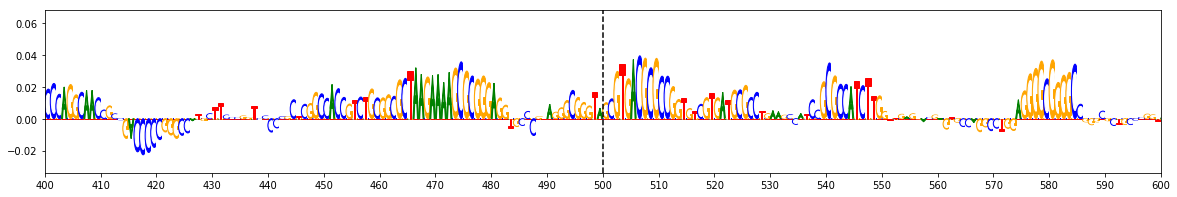

Index:  10  Delta:  -0.278293017  RSID:  rs2279904
Minor - Major:  A - C


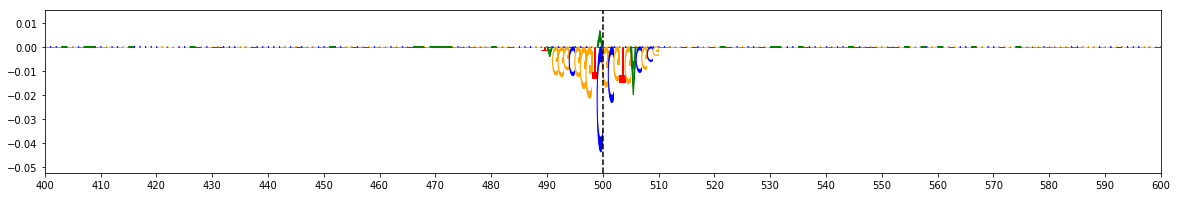

Index:  20  Importance:  0.27493878699999996  RSID:  rs4717309   chr7 : 66147588 - 66147589  Locus:  211
Major Allele:  T


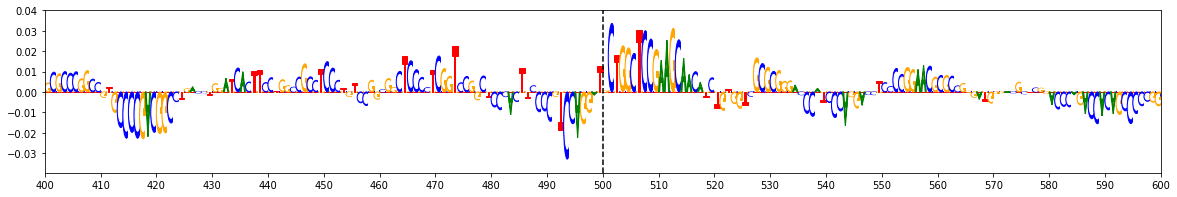

Index:  20  Importance:  0.07040631400000005  RSID:  rs4717309
Minor Allele:  C


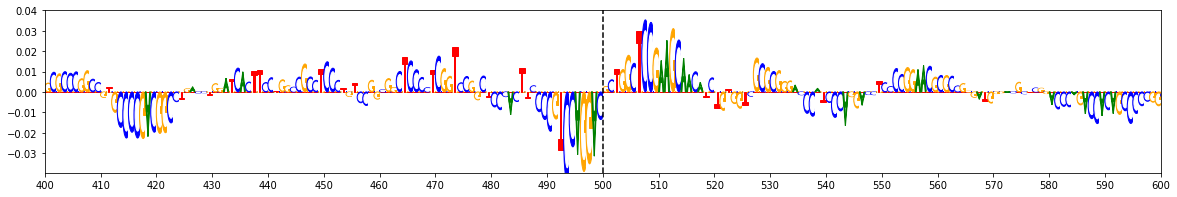

Index:  20  Delta:  -0.2045324729999999  RSID:  rs4717309
Minor - Major:  C - T


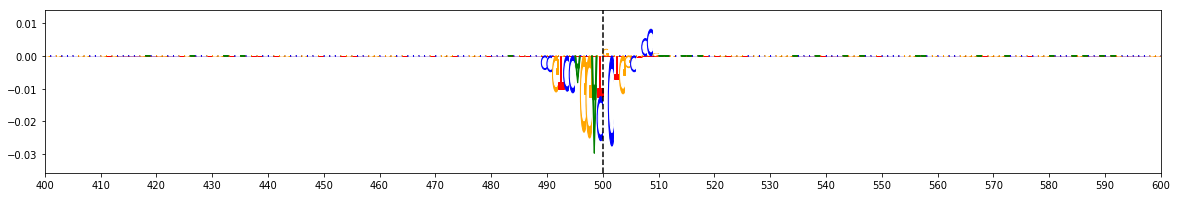

Index:  18  Importance:  1.5197769256  RSID:  rs4078168   chr7 : 66119816 - 66119817  Locus:  211
Major Allele:  C


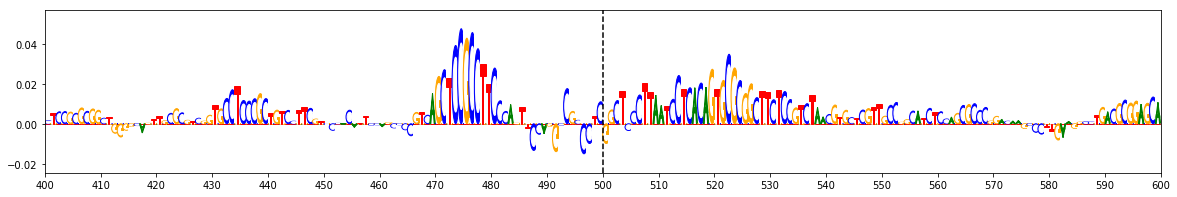

Index:  18  Importance:  1.3312494454000001  RSID:  rs4078168
Minor Allele:  G


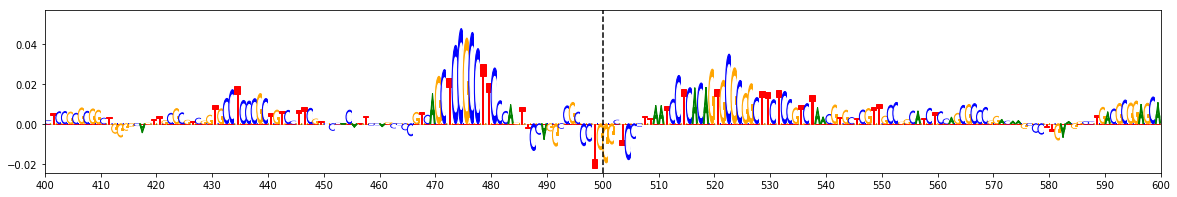

Index:  18  Delta:  -0.18852748019999988  RSID:  rs4078168
Minor - Major:  G - C


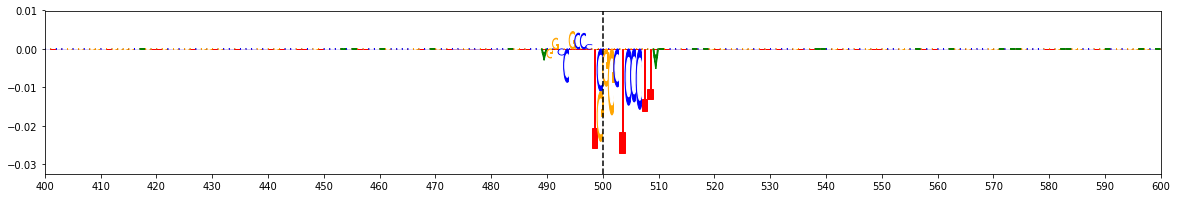

Index:  5  Importance:  1.7971510334  RSID:  rs2072369   chr7 : 23146188 - 23146189  Locus:  210
Major Allele:  A


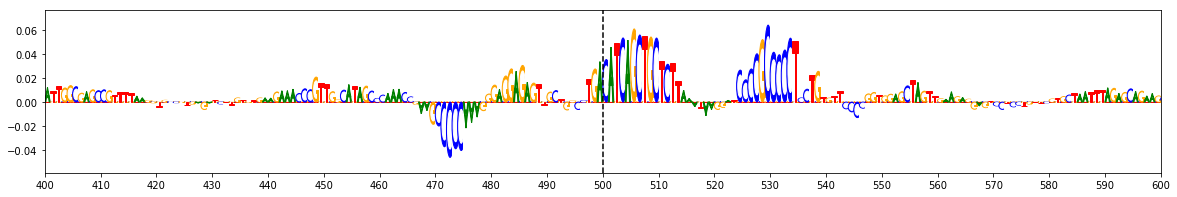

Index:  5  Importance:  1.6100013024  RSID:  rs2072369
Minor Allele:  G


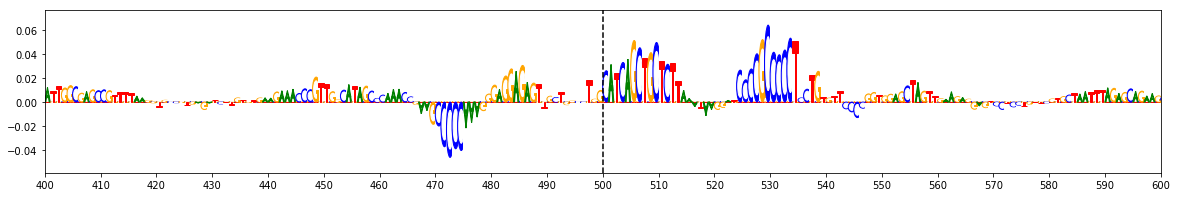

Index:  5  Delta:  -0.1871497310000001  RSID:  rs2072369
Minor - Major:  G - A


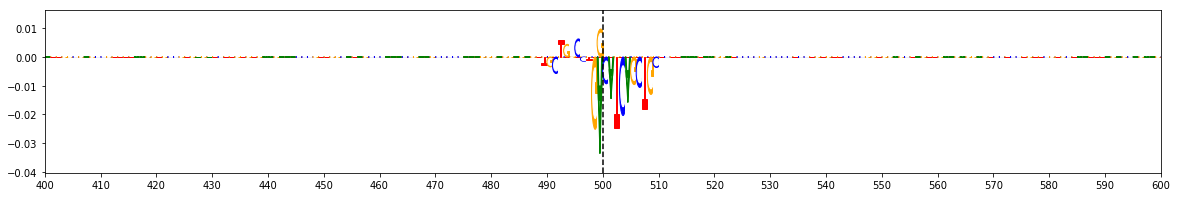

In [14]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [15]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
13,13,chr7,65842533,65842534,rs62465362,211,T,G,0.444516,0.706519,0.262003
15,15,chr7,65925018,65925019,rs12540356,211,A,G,1.475371,1.660121,0.184750
21,21,chr7,66205935,66205936,rs2279934,211,C,G,1.379905,1.555343,0.175438
2,2,chr7,23144946,23144947,rs10256524,210,T,G,0.909628,0.990619,0.080991
7,7,chr7,23185498,23185499,rs6978478,210,A,G,-0.102738,-0.030510,0.072229
1,1,chr7,23144946,23144947,rs10256524,210,T,C,0.909628,0.971798,0.062169
14,14,chr7,65925018,65925019,rs12540356,211,A,C,1.475371,1.515471,0.040100
12,12,chr7,65842533,65842534,rs62465362,211,T,C,0.444516,0.459131,0.014615
6,6,chr7,23185494,23185495,rs6978475,210,A,G,-0.142442,-0.132069,0.010373
11,11,chr7,65551820,65551821,rs12536292,211,C,T,-0.363558,-0.356685,0.006873


## Get 10 bp around SNP

In [16]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

GTTCGGGCAGCCAACACACG
GTTCGGGCAG | CCAACACACG
TTAAGAGCTGGAAAAAAAAT
TTAAGAGCTG | GAAAAAAAAT
TCCTTCGTCGCACATTCCGT
TCCTTCGTCG | CACATTCCGT
CTTGCGTTAGGAATCCCACG
CTTGCGTTAG | GAATCCCACG
CAGGCACACGCCACTATGCC
CAGGCACACG | CCACTATGCC


## Visualize Top Sequences

Index:  13  Importance:  0.706518669  RSID:  rs62465362 chr7 :  65842533  -  65842534  Locus:  211
Minor Allele:  G


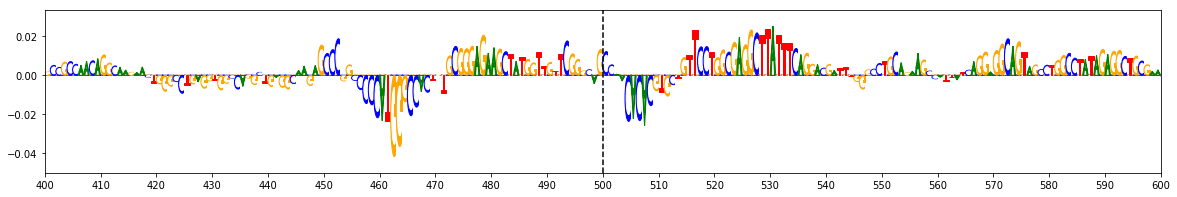

Index:  13  Importance:  0.44451612399999985  RSID:  rs62465362
Major Allele:  T


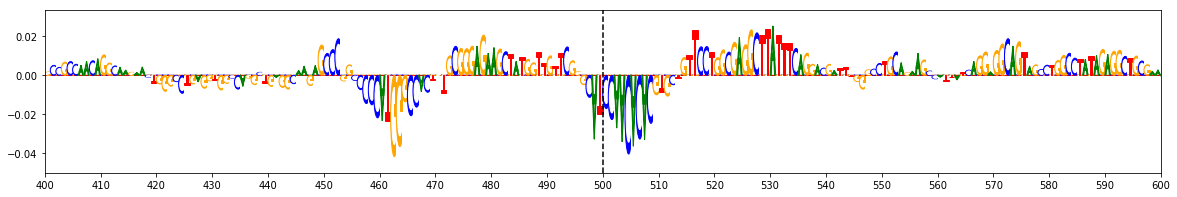

Index:  13  Delta:  0.2620025450000002  RSID:  rs62465362
Minor - Major:  G - T


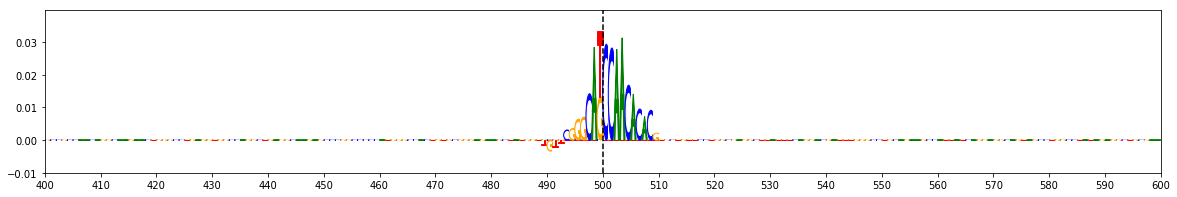

Index:  15  Importance:  1.66012135314  RSID:  rs12540356 chr7 :  65925018  -  65925019  Locus:  211
Minor Allele:  G


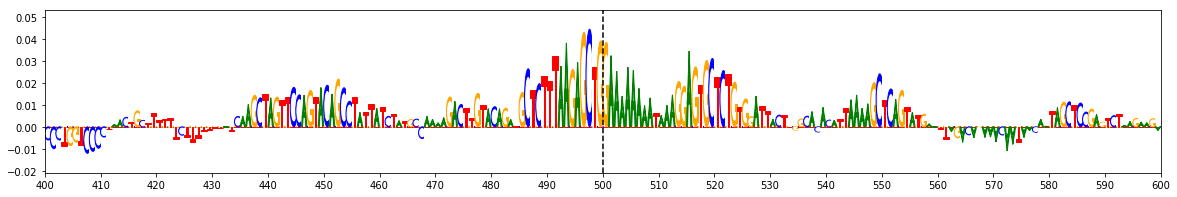

Index:  15  Importance:  1.47537087073  RSID:  rs12540356
Major Allele:  A


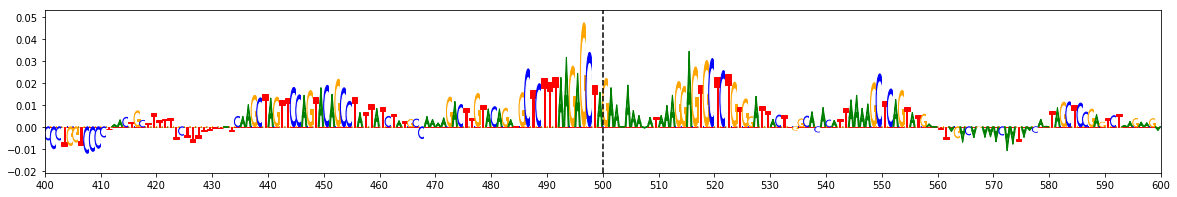

Index:  15  Delta:  0.18475048241000014  RSID:  rs12540356
Minor - Major:  G - A


E0927 00:22:48.601607 140692450940672 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-25faf14f3664>", line 11, in <module>
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
  File "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm/viz_sequence.py", line 162, in plot_weights
    ylabel=ylabel)
  File "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm/viz_sequence.py", line 104, in plot_weights_given_ax
    plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
  File "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm/viz_sequence.py", line 46, in plot_c
    facecolor='white', edgecolor='white', fill=True))
  File "/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/matplotlib/patches.py", line 686, in __init__
    Patch.__

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff5557a2378> (for post_execute):


KeyboardInterrupt: 

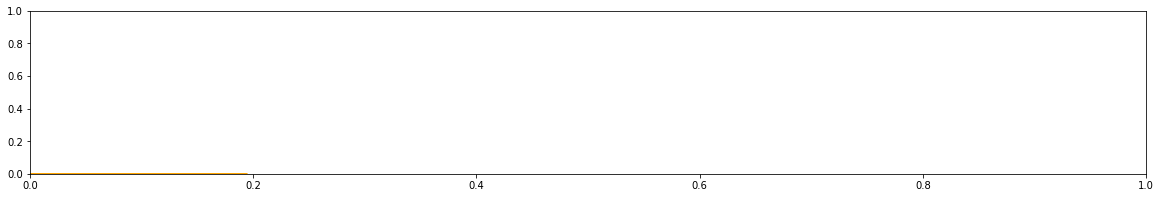

In [17]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

# Fold 7

## Prepare Reference Alleles

In [18]:
cluster = '5'
fold = '7'
peak = 'overlap'
gwas = '23andme_PD'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 13


## Prepare Alternate Alleles

In [19]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 13


## Find Alternate Alleles that Break Accessibility

In [20]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
0,0,chr17,43795858,43795859,rs111985258,204,A,G,-0.081552,-0.273213,-0.191662
6,6,chr17,44344408,44344409,rs111413387,204,A,C,1.733971,1.549532,-0.184440
2,2,chr17,44344357,44344358,rs113182122,204,T,C,1.269622,1.104473,-0.165149
11,11,chr17,44344594,44344595,rs117995241,204,G,T,1.242541,1.185366,-0.057175
5,5,chr17,44344384,44344385,rs112464485,204,G,C,1.396627,1.371773,-0.024854
1,1,chr17,44344238,44344239,rs113613291,204,A,T,2.228553,2.204222,-0.024331
7,7,chr17,44344445,44344446,rs112539198,204,G,A,2.234488,2.279080,0.044592
10,10,chr17,44344551,44344552,rs113830390,204,C,T,1.727603,1.824225,0.096622
8,8,chr17,44344445,44344446,rs112539198,204,G,T,2.234488,2.364957,0.130469
12,12,chr17,44344595,44344596,rs117629202,204,C,A,1.237945,1.407636,0.169690


## Get 10 bp around SNP

In [21]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

GGACTACAGACAGTGCCACC
GGACTACAGA | CAGTGCCACC
CAGCTTCAGATTCGGCCTCA
CAGCTTCAGA | TTCGGCCTCA
GCGCGCCGTTGTGCCGGCCC
GCGCGCCGTT | GTGCCGGCCC
TCCCAGGGCGCCCGACCCAT
TCCCAGGGCG | CCCGACCCAT
GCCGCCCGCGCCGCCGCCGC
GCCGCCCGCG | CCGCCGCCGC


## Visualize Top Sequences

Index:  0  Importance:  -0.08155162108000008  RSID:  rs111985258   chr17 : 43795858 - 43795859  Locus:  204
Major Allele:  A


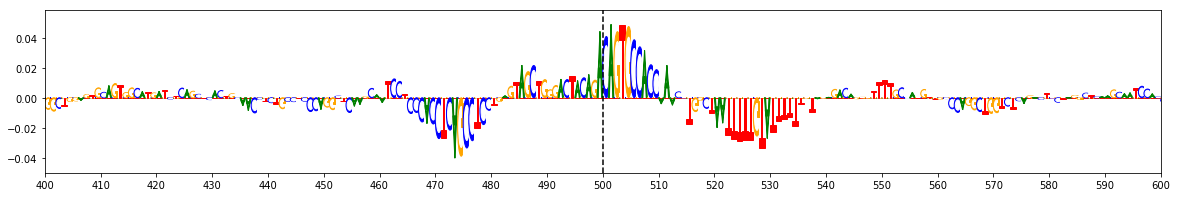

Index:  0  Importance:  -0.2732132837000001  RSID:  rs111985258
Minor Allele:  G


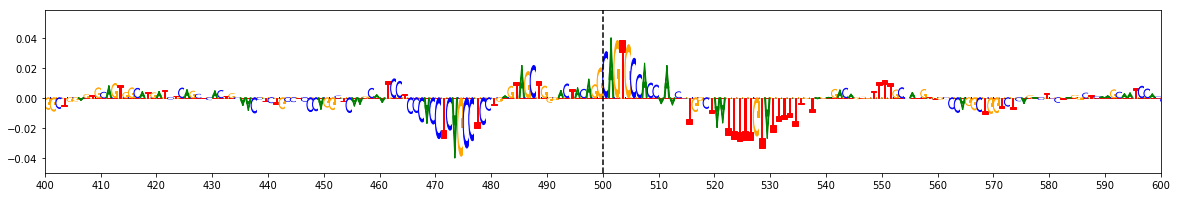

Index:  0  Delta:  -0.19166166262  RSID:  rs111985258
Minor - Major:  G - A


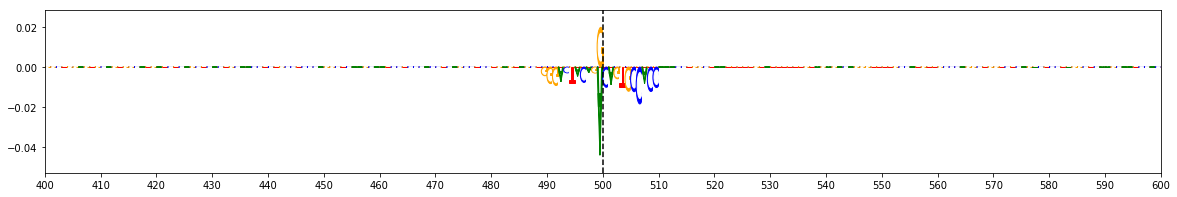

Index:  6  Importance:  1.73397137308  RSID:  rs111413387   chr17 : 44344408 - 44344409  Locus:  204
Major Allele:  A


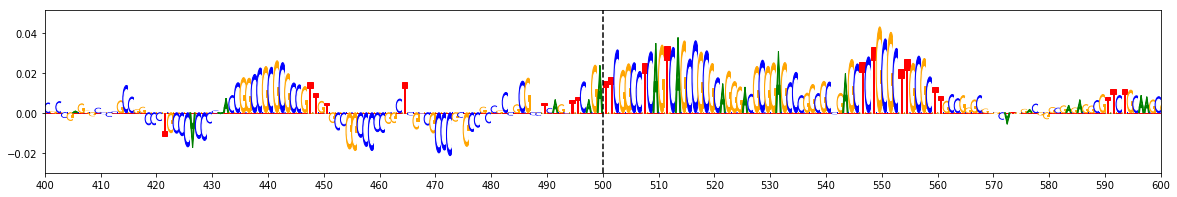

Index:  6  Importance:  1.5495317141  RSID:  rs111413387
Minor Allele:  C


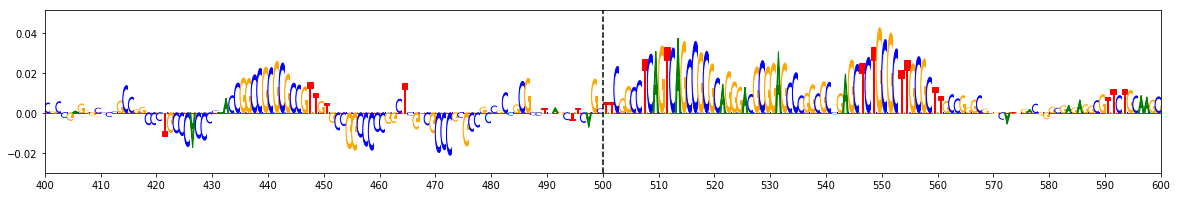

Index:  6  Delta:  -0.18443965897999992  RSID:  rs111413387
Minor - Major:  C - A


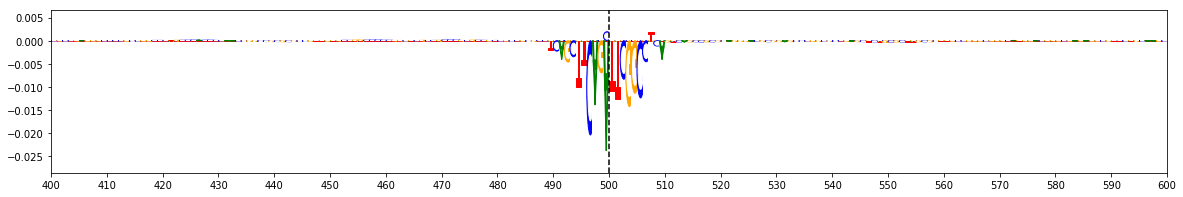

Index:  2  Importance:  1.2696222041000003  RSID:  rs113182122   chr17 : 44344357 - 44344358  Locus:  204
Major Allele:  T


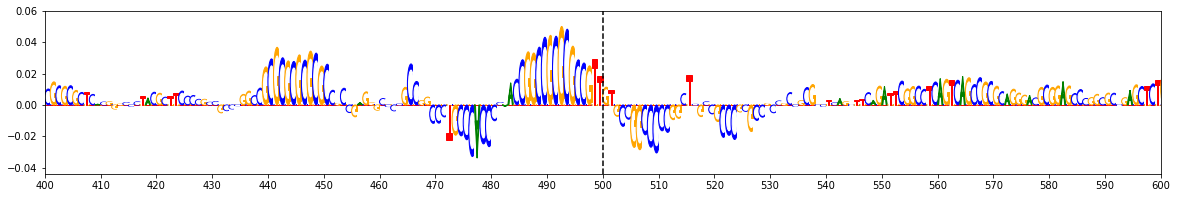

Index:  2  Importance:  1.1044729631999999  RSID:  rs113182122
Minor Allele:  C


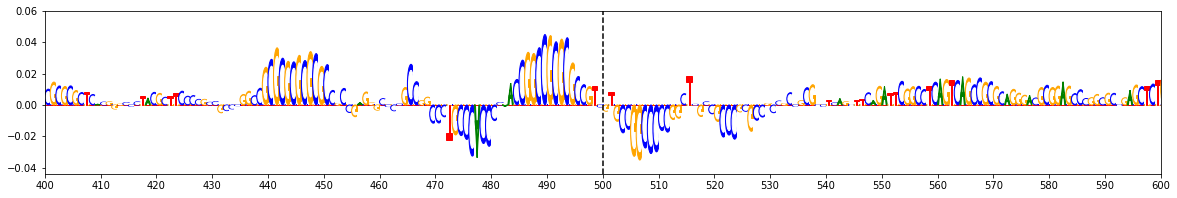

Index:  2  Delta:  -0.16514924090000038  RSID:  rs113182122
Minor - Major:  C - T


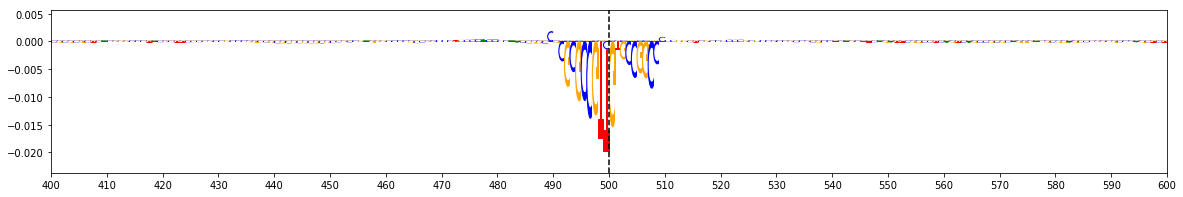

Index:  11  Importance:  1.2425410208  RSID:  rs117995241   chr17 : 44344594 - 44344595  Locus:  204
Major Allele:  G


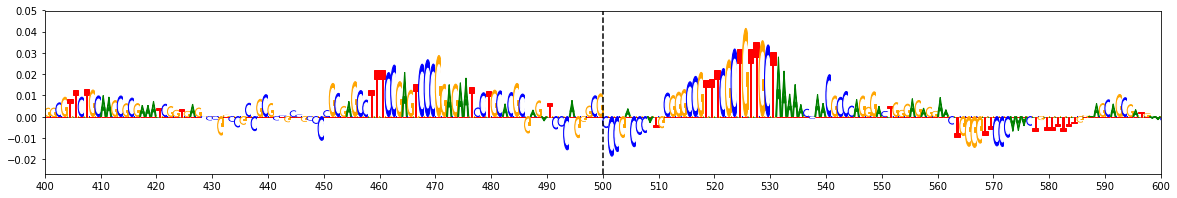

Index:  11  Importance:  1.1853658908  RSID:  rs117995241
Minor Allele:  T


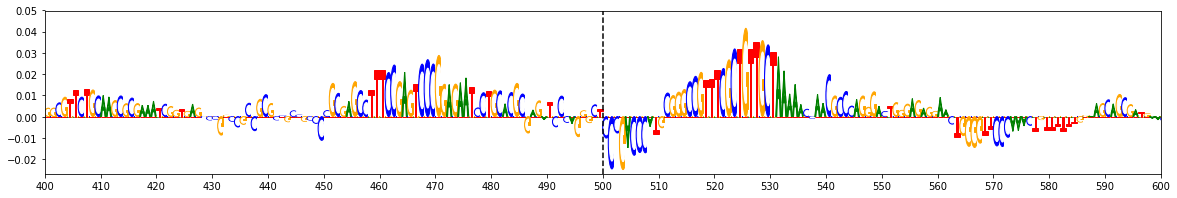

Index:  11  Delta:  -0.057175130000000074  RSID:  rs117995241
Minor - Major:  T - G


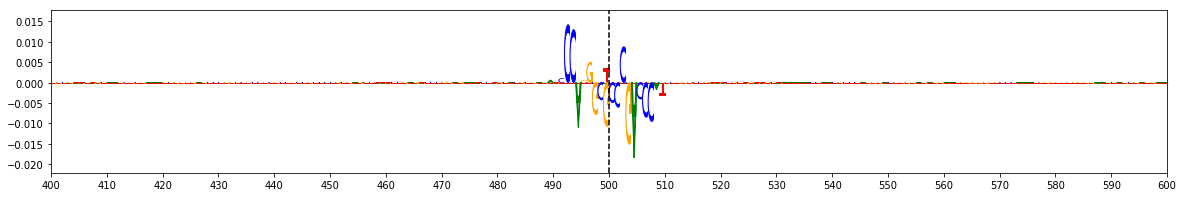

Index:  5  Importance:  1.3966268214000002  RSID:  rs112464485   chr17 : 44344384 - 44344385  Locus:  204
Major Allele:  G


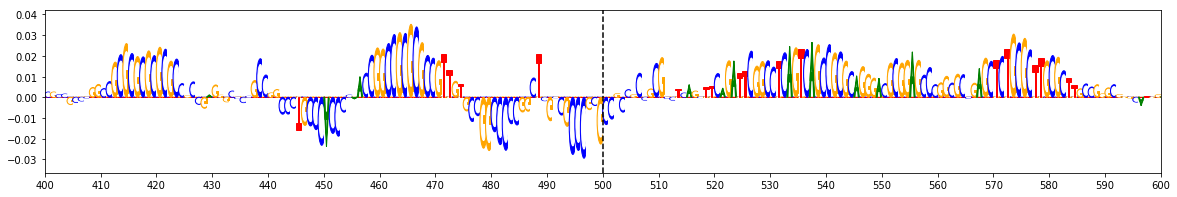

Index:  5  Importance:  1.3717728248999999  RSID:  rs112464485
Minor Allele:  C


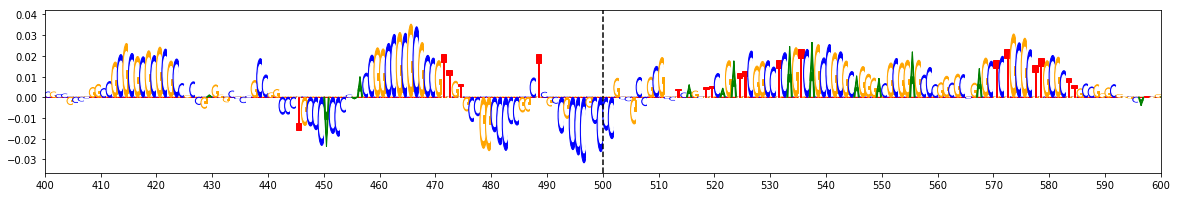

Index:  5  Delta:  -0.024853996500000308  RSID:  rs112464485
Minor - Major:  C - G


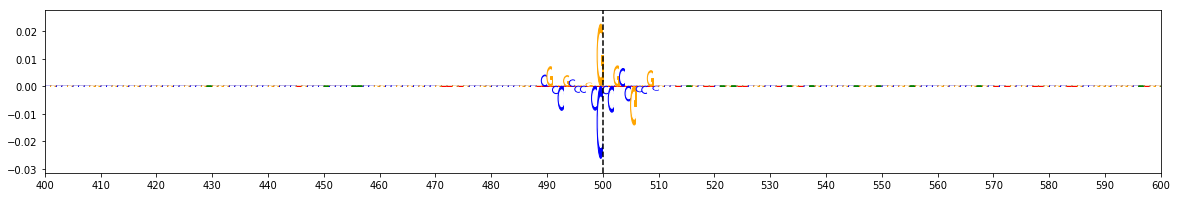

In [22]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [23]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
4,4,chr17,44344384,44344385,rs112464485,204,G,A,1.396627,1.895740,0.499113
9,9,chr17,44344540,44344541,rs111854089,204,C,A,1.705001,2.066099,0.361098
3,3,chr17,44344375,44344376,rs112534607,204,G,A,1.363361,1.654861,0.291500
12,12,chr17,44344595,44344596,rs117629202,204,C,A,1.237945,1.407636,0.169690
8,8,chr17,44344445,44344446,rs112539198,204,G,T,2.234488,2.364957,0.130469
10,10,chr17,44344551,44344552,rs113830390,204,C,T,1.727603,1.824225,0.096622
7,7,chr17,44344445,44344446,rs112539198,204,G,A,2.234488,2.279080,0.044592
1,1,chr17,44344238,44344239,rs113613291,204,A,T,2.228553,2.204222,-0.024331
5,5,chr17,44344384,44344385,rs112464485,204,G,C,1.396627,1.371773,-0.024854
11,11,chr17,44344594,44344595,rs117995241,204,G,T,1.242541,1.185366,-0.057175


## Get 10 bp around SNP

In [24]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

GCCGCCCGCACCGCCGCCGC
GCCGCCCGCA | CCGCCGCCGC
CCGCGCCGCAGCCCCGCGAG
CCGCGCCGCA | GCCCCGCGAG
CCCCGGCTCACCGCCCGCGC
CCCCGGCTCA | CCGCCCGCGC
CCCAGGGCGACCGACCCATG
CCCAGGGCGA | CCGACCCATG
GCGGAGCCCTGCGCCGAGCT
GCGGAGCCCT | GCGCCGAGCT


## Visualize Top Sequences

Index:  4  Importance:  1.8957397934999998  RSID:  rs112464485 chr17 :  44344384  -  44344385  Locus:  204
Minor Allele:  A


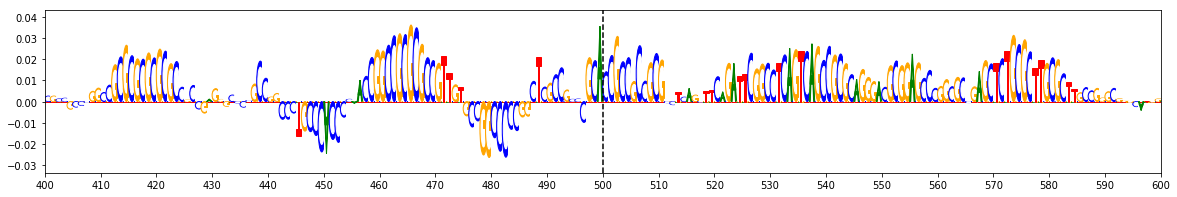

Index:  4  Importance:  1.3966268214000002  RSID:  rs112464485
Major Allele:  G


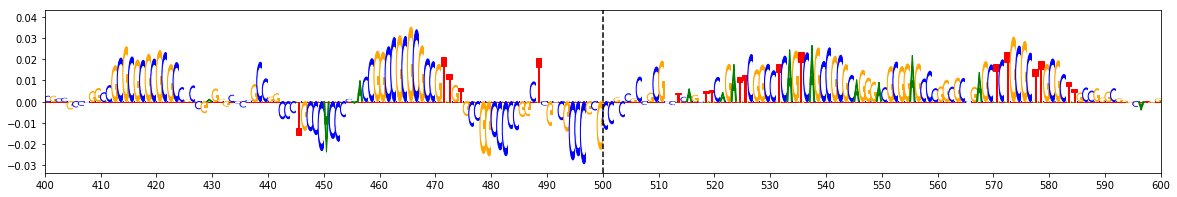

Index:  4  Delta:  0.4991129720999996  RSID:  rs112464485
Minor - Major:  A - G


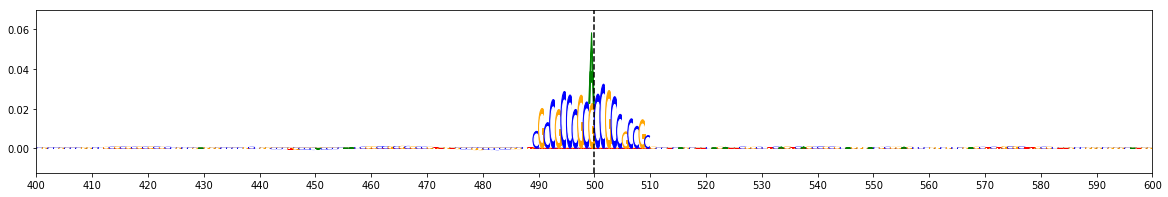

Index:  9  Importance:  2.0660991220000002  RSID:  rs111854089 chr17 :  44344540  -  44344541  Locus:  204
Minor Allele:  A


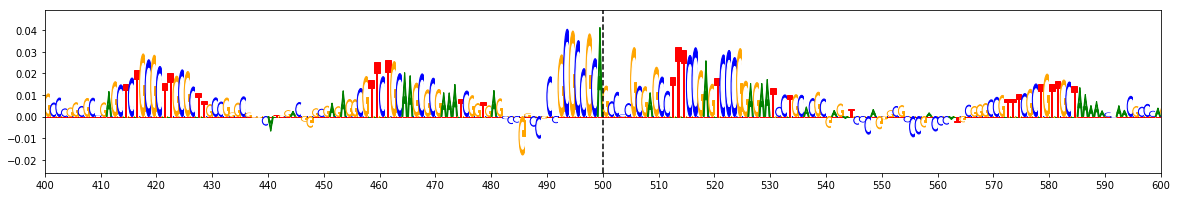

Index:  9  Importance:  1.705000648  RSID:  rs111854089
Major Allele:  C


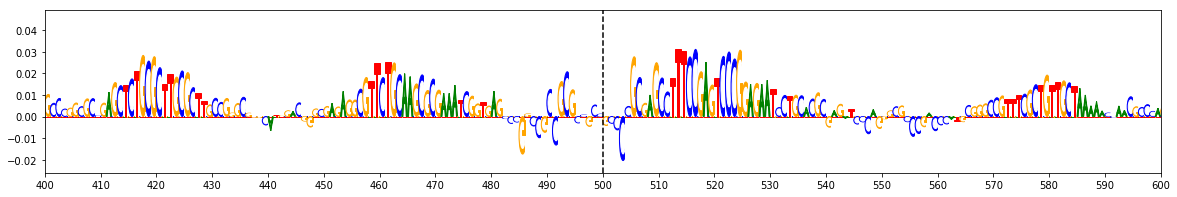

Index:  9  Delta:  0.3610984740000003  RSID:  rs111854089
Minor - Major:  A - C


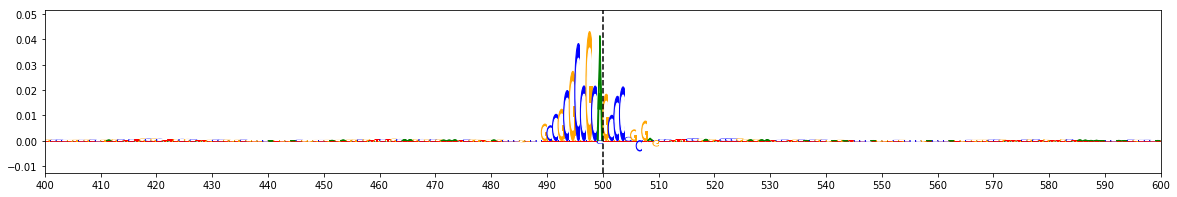

Index:  3  Importance:  1.6548608821  RSID:  rs112534607 chr17 :  44344375  -  44344376  Locus:  204
Minor Allele:  A


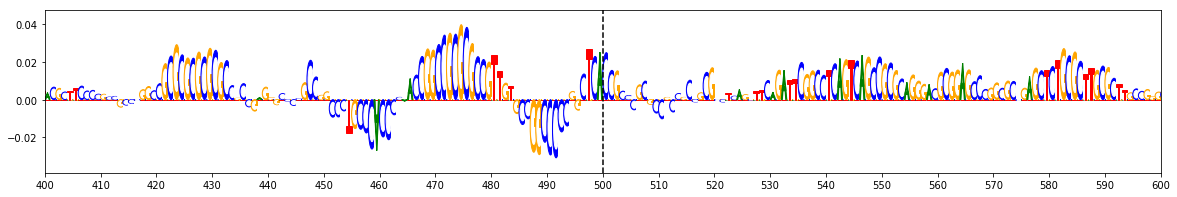

Index:  3  Importance:  1.3633613214999998  RSID:  rs112534607
Major Allele:  G


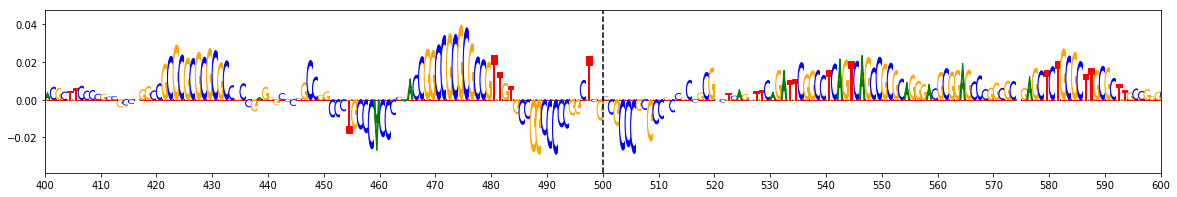

Index:  3  Delta:  0.29149956060000015  RSID:  rs112534607
Minor - Major:  A - G


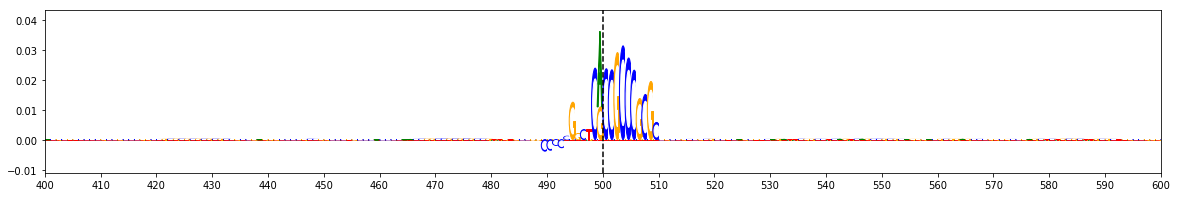

Index:  12  Importance:  1.407635509  RSID:  rs117629202 chr17 :  44344595  -  44344596  Locus:  204
Minor Allele:  A


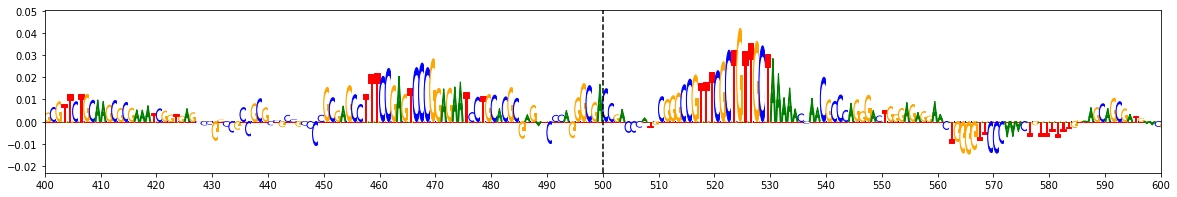

Index:  12  Importance:  1.2379450319999998  RSID:  rs117629202
Major Allele:  C


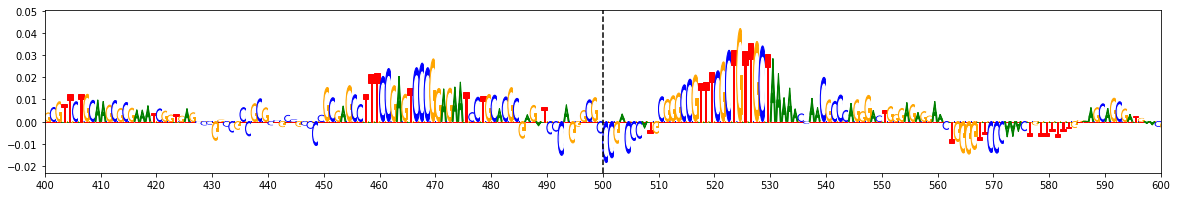

Index:  12  Delta:  0.16969047700000006  RSID:  rs117629202
Minor - Major:  A - C


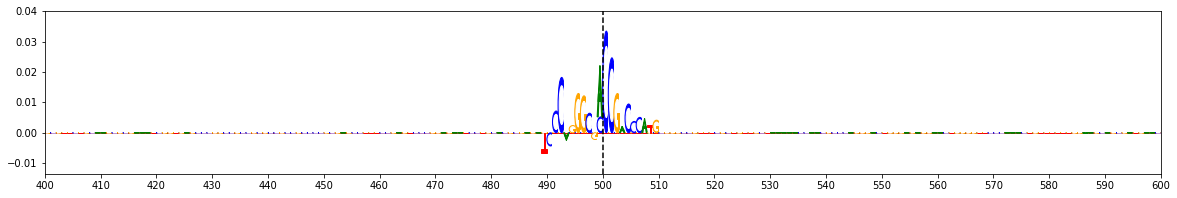

Index:  8  Importance:  2.3649567615000002  RSID:  rs112539198 chr17 :  44344445  -  44344446  Locus:  204
Minor Allele:  T


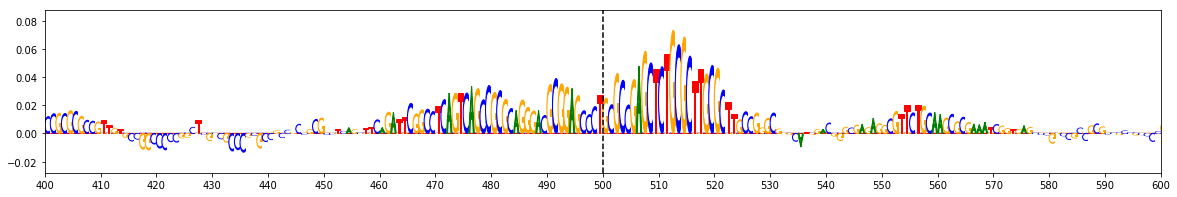

Index:  8  Importance:  2.234488043  RSID:  rs112539198
Major Allele:  G


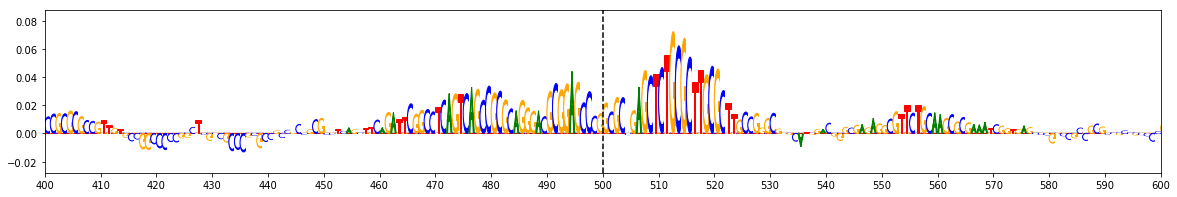

Index:  8  Delta:  0.1304687185000004  RSID:  rs112539198
Minor - Major:  T - G


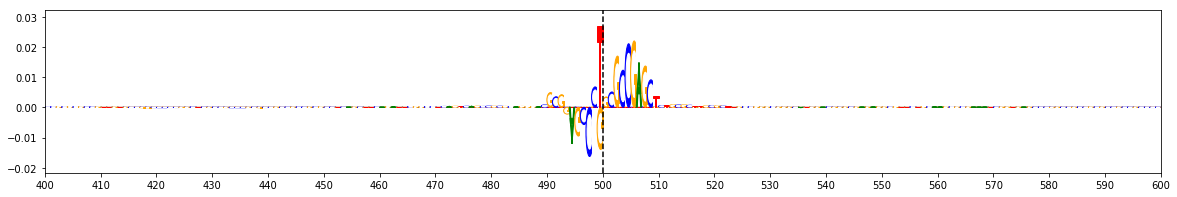

In [25]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))